# Import Libraries

In [60]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm

# Options

In [61]:
multiStart = True

# Initialize Paramters

In [62]:

T2_size = 10
TE_size = 64

c_array = 0.5
T2_array = np.linspace(40,160,T2_size)

TE_array = np.linspace(8,8*TE_size,TE_size)

if multiStart:
    starts = 20
else:
    starts = 1

SNR = 1000

iterations = 100

weights_moX = [1,1/100]
weights_biX = [1,1,1/100,1/100]

RSS_array_moX = np.zeros((iterations,T2_array.shape[0]))
RSS_array_biX = np.zeros((iterations,T2_array.shape[0]))

pErr_array_moX = np.zeros((iterations,T2_array.shape[0]))
pErr_array_biX = np.zeros((iterations,T2_array.shape[0]))

RSS_noise_moX = np.zeros((iterations,T2_array.shape[0]))
RSS_noise_biX = np.zeros((iterations,T2_array.shape[0]))

RSS_disconnect_moX = np.zeros((T2_array.shape[0],1))
RSS_disconnect_biX = np.zeros((T2_array.shape[0],1))

pseudo_moX = np.zeros((T2_array.shape[0],1))

details = str('\nTE Points: ' + str(TE_size) + " :: Starts " + str(starts) +
            '\nIterations: ' + str(iterations) + ' :: SNR: ' + str(SNR))

# Signal Functions

In [63]:
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def add_noise(data,SNR):
    sigma = np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

# Curve Fitting

In [64]:
for iT2 in trange(T2_array.shape[0]):

    T2 = T2_array[iT2]
    true_sig = S_moX_2p(TE_array,c_array,T2)

    for iter in range(iterations):

        noised_sig = add_noise(true_sig,SNR)

        paramTemp_moX = np.zeros((starts,2))
        paramTemp_biX = np.zeros((starts,4))
        RSS_Temp_moX = np.ones(starts)*np.inf
        RSS_Temp_biX = np.ones(starts)*np.inf

        RSS_Noise_moX = np.ones(starts)*np.inf
        RSS_Noise_biX = np.ones(starts)*np.inf

        RSS_disconnect_moX_count = 0
        RSS_disconnect_biX_count = 0

        pseudo_moX_count = 0

        for start in range(starts):

            lb_moX = (0,1)
            ub_moX = (1,300)

            init_p_moX = tuple(np.add(np.subtract(ub_moX,lb_moX)*np.random.uniform(0,1,np.size(lb_moX)),lb_moX))

            popt_moX, pcov_moX = curve_fit( S_moX_2p, TE_array, noised_sig, p0 = init_p_moX, bounds = [lb_moX,ub_moX], method = 'trf', maxfev = 1500)

            paramTemp_moX[start,:] = popt_moX
            RSS_Temp_moX = np.sum((true_sig - S_moX_2p(TE_array, *popt_moX))**2)
            RSS_Noise_moX = np.sum((noised_sig - S_moX_2p(TE_array, *popt_moX))**2)

            lb_biX = (0,0,1,1)
            ub_biX = (1,1,300,300)

            init_p_biX = tuple(np.add(np.subtract(ub_biX,lb_biX)*np.random.uniform(0,1,np.size(lb_biX)),lb_biX))

            popt_biX, pcov_biX = curve_fit( S_biX_4p, TE_array, noised_sig, p0 = init_p_biX, bounds = [lb_biX,ub_biX], method = 'trf', maxfev = 1500)

            paramTemp_biX[start,:] = popt_biX
            RSS_Temp_biX = np.sum((true_sig - S_biX_4p(TE_array, *popt_biX))**2)
            RSS_Noise_biX = np.sum((noised_sig - S_biX_4p(TE_array, *popt_biX))**2)

        RSS_array_moX[iter,iT2] = np.min(RSS_Temp_moX)
        RSS_array_biX[iter,iT2] = np.min(RSS_Temp_biX)

        RSS_noise_moX[iter,iT2] = np.min(RSS_Noise_moX)
        RSS_noise_biX[iter,iT2] = np.min(RSS_Noise_biX)

        if np.argmin(RSS_Temp_moX) != np.argmin(RSS_Noise_moX):
            RSS_disconnect_moX_count += 1

        if np.argmin(RSS_Temp_biX) != np.argmin(RSS_Noise_biX):
            RSS_disconnect_biX_count += 1

        pErr_array_moX[iter,iT2] = np.linalg.norm((paramTemp_moX[np.argmin(RSS_Temp_moX),:] - (c_array, T2))*weights_moX)

        if (np.abs(paramTemp_biX[np.argmin(RSS_Temp_biX),2] - paramTemp_biX[np.argmin(RSS_Temp_biX),3]) < 10 and
            np.abs(paramTemp_biX[np.argmin(RSS_Temp_biX),0] + paramTemp_biX[np.argmin(RSS_Temp_biX),1] - c_array) < 0.05):
            pseudo_moX_count += 1

        err1 = np.linalg.norm((paramTemp_biX[np.argmin(RSS_Temp_biX),(1,3)] - (c_array, T2))*weights_moX)
        err2 = np.linalg.norm((paramTemp_biX[np.argmin(RSS_Temp_biX),(0,2)] - (c_array, T2))*weights_moX)
        pErr_array_biX[iter,iT2] = np.min([err1,err2])

    RSS_disconnect_moX[iT2] = RSS_disconnect_moX_count
    RSS_disconnect_biX[iT2] = RSS_disconnect_biX_count

    pseudo_moX[iT2] = pseudo_moX_count


100%|██████████| 10/10 [11:08<00:00, 66.86s/it]


# Graphs

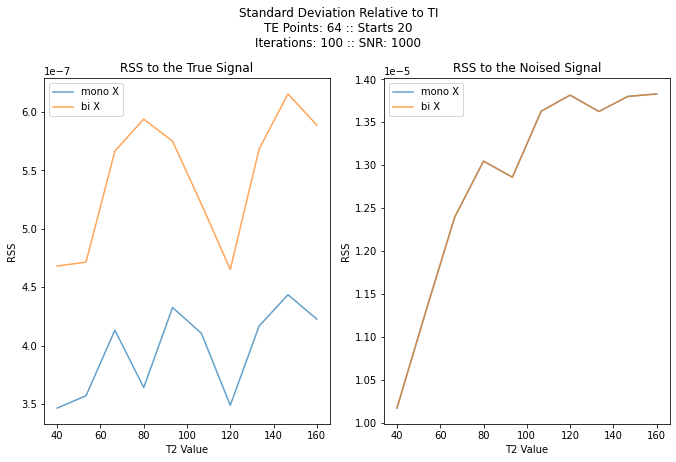

In [65]:
avg_RSS_moX = np.mean(RSS_array_moX, axis = 0)
avg_RSS_biX = np.mean(RSS_array_biX, axis = 0)
avg_RSS_noise_moX = np.mean(RSS_noise_moX, axis = 0)
avg_RSS_noise_biX = np.mean(RSS_noise_moX, axis = 0)

fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('Standard Deviation Relative to TI' + details)

ax[0].plot(T2_array, avg_RSS_moX, label = "mono X", alpha = 0.7)
ax[0].plot(T2_array, avg_RSS_biX, label = "bi X", alpha = 0.7)
ax[0].set_xlabel('T2 Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('RSS to the True Signal')
ax[0].legend()

ax[1].plot(T2_array, avg_RSS_noise_moX, label = "mono X", alpha = 0.7)
ax[1].plot(T2_array, avg_RSS_noise_biX, label = "bi X", alpha = 0.7)
ax[1].set_xlabel('T2 Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS to the Noised Signal')
ax[1].legend()

plt.show()

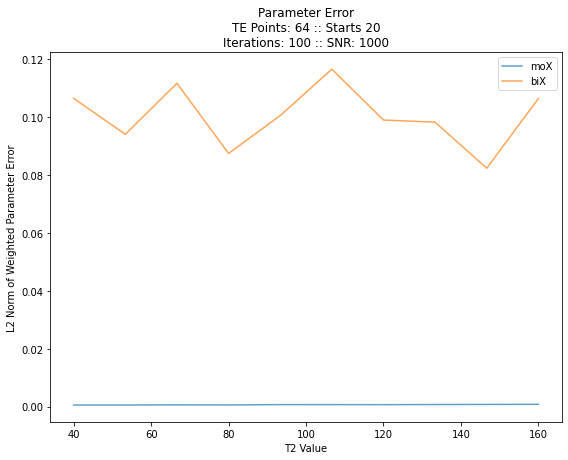

In [66]:
avg_pErr_moX = np.mean(pErr_array_moX, axis = 0)
avg_pErr_biX = np.mean(pErr_array_biX, axis = 0)

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,avg_pErr_moX, label = 'moX', alpha = 0.7)
plt.plot(T2_array,avg_pErr_biX, label = 'biX', alpha = 0.7)
plt.xlabel('T2 Value')
plt.ylabel('L2 Norm of Weighted Parameter Error')
plt.title('Parameter Error' + details)
plt.legend()
plt.tight_layout()
plt.show()

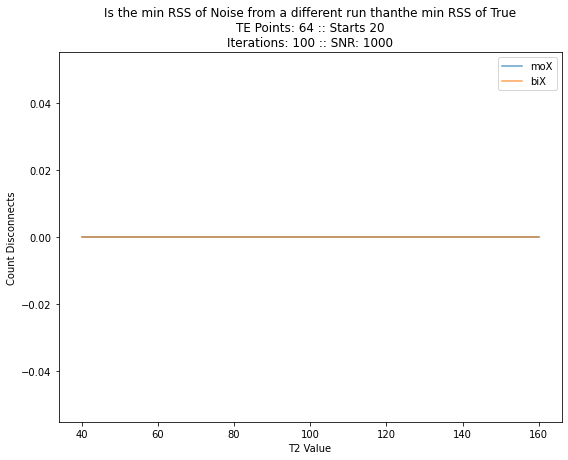

In [69]:
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,RSS_disconnect_moX, label = 'moX', alpha = 0.7)
plt.plot(T2_array,RSS_disconnect_biX, label = 'biX', alpha = 0.7)
plt.xlabel('T2 Value')
plt.ylabel('Count Disconnects')
plt.title('Is the min RSS of Noise from a different run thanthe min RSS of True' + details)
plt.legend()
plt.tight_layout()
plt.show()

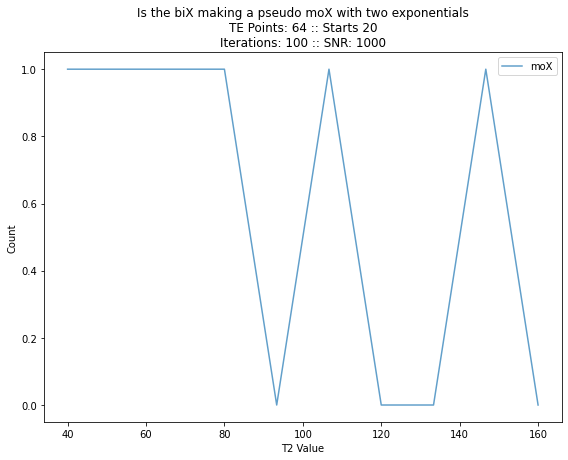

In [68]:
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,pseudo_moX, label = 'moX', alpha = 0.7)
plt.xlabel('T2 Value')
plt.ylabel('Count')
plt.title('Is the biX making a pseudo moX with two exponentials' + details)
plt.legend()
plt.tight_layout()
plt.show()